In [1]:
import urllib

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os
from PIL import Image
tf.compat.v1.enable_v2_behavior()

from rcnn_sat.rcnn_sat.preprocess import preprocess_image
from rcnn_sat.rcnn_sat.bl_net import bl_net

from data.generate_symmetry_images import make_random, make_images

## Data

In [3]:
def preprocess_ims(ims):
    return np.asarray([preprocess_image(np.asarray(Image.fromarray(x.astype("uint8")).convert("RGB").resize((128, 128)))) for x in ims])

In [4]:
# Replace this path with the path to Experiment Set 1 data
DATA_DIR = "/om/user/shobhita/src/symmetry/experiment_set_1/data/"

IMG_SIZE = (80, 80)
TRAIN_SIZE = 4000
TEST_CATS = [
    "band0", 
    "band2", 
    "band4", 
    "band6", 
    "bandd4", 
    "band14", 
    "band16", 
    "band18"
]
BATCH_SIZE = 32

# /om/user/shobhita/src/symmetry/data/symm_synthetic_training_4000_80px.pkl

train_dir = os.path.join(f"{DATA_DIR}symm_synthetic_training_{TRAIN_SIZE}_{IMG_SIZE[0]}px.pkl")
with open(train_dir, "rb") as handle:
    train_dataset_raw = pickle.load(handle)
    
val_dir = os.path.join(f"{DATA_DIR}symm_synthetic_validation_{TRAIN_SIZE}_{IMG_SIZE[0]}px.pkl")
with open(val_dir, "rb") as handle:
    val_dataset_raw = pickle.load(handle)

test_datasets_raw = {}
for test_cat in TEST_CATS:
    test_dir = os.path.join(f"{DATA_DIR}symm_{test_cat}_{IMG_SIZE[0]}_test.pkl")
    with open(test_dir, "rb") as handle:
        test_dataset = pickle.load(handle)    
    test_datasets_raw[test_cat] = test_dataset
    
print("Loading training dataset")
images = np.array([sample[0] for sample in train_dataset_raw])
images = preprocess_ims(images)
labels = np.array([sample[1] for sample in train_dataset_raw])
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)

print("Loading validation dataset")
images = np.array([sample[0] for sample in val_dataset_raw])
images = preprocess_ims(images)
labels = np.array([sample[1] for sample in val_dataset_raw])
val_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)

print("Loading test datasets")
test_datasets = {}

for test_cat, test_raw_ds in test_datasets_raw.items():
    test_images = np.array([sample[0] for sample in test_raw_ds])
    test_images = preprocess_ims(test_images)
    test_labels = np.array([sample[1] for sample in test_raw_ds])
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)
    test_datasets[test_cat] = test_ds
    
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
for key in test_datasets:
    test_datasets[key] = test_datasets[key].prefetch(buffer_size=AUTOTUNE)

Loading training dataset
Loading validation dataset
Loading test datasets


## Plot Samples

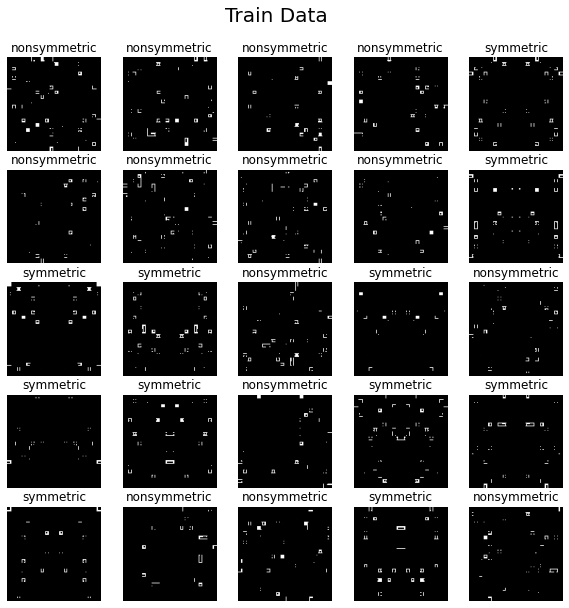

In [4]:
plt.figure(figsize=(10, 10))
class_names = ["nonsymmetric", "symmetric"]
plt.suptitle("Train Data", y=0.95, fontsize=20)
for images, labels in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

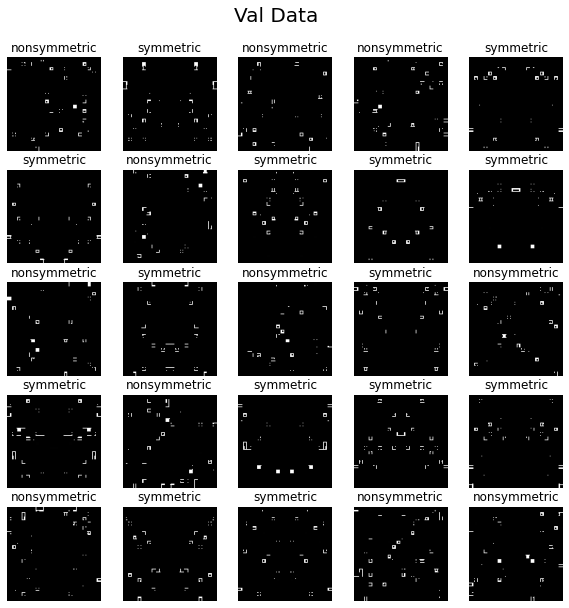

In [5]:
plt.figure(figsize=(10, 10))
class_names = ["nonsymmetric", "symmetric"]
plt.suptitle("Val Data", y=0.95, fontsize=20)
for images, labels in val_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
class_names = ["nonsymmetric", "symmetric"]
plt.suptitle("Test Data", y=0.95, fontsize=20)
for images, labels in test_datasets[.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Training

In [12]:
def get_model(base_model_trainable=True):
    input_layer = tf.keras.layers.Input((128, 128, 3))
    base_model = bl_net(input_layer, classes=565, cumulative_readout=True)
    base_model.load_weights('bl_imagenet.h5')
    base_model.trainable = base_model_trainable
    
    dense_layer = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(1e-6), name="Symmetry_Dense")

    dense_readout = [None for _ in range(8)]
    for ts in range(8):
        dense_readout[ts] = dense_layer(base_model.get_layer(f'GlobalAvgPool_Time_{ts}').output)

    outputs = tf.keras.layers.Average()(dense_readout)

    model = tf.keras.Model(input_layer, outputs)
    
    return model

In [13]:
model = get_model(base_model_trainable=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
RCL_0_BConv (Conv2D)            (None, 128, 128, 96) 14112       input_2[0][0]                    
__________________________________________________________________________________________________
RCL_0_ConvSum (Lambda)          (None, 128, 128, 96) 0           RCL_0_BConv[0][0]                
                                                                 RCL_0_BConv[0][0]                
                                                                 RCL_0_LConv[0][0]                
                                                                 RCL_0_BConv[0][0]          

In [14]:
base_learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 4s 195ms/step - loss: 0.7581 - accuracy: 0.3933


In [36]:
print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")

initial loss: 0.7604091763496399
initial accuracy: 0.4000000059604645


In [17]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset)

Epoch 1/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3439 - accuracy: 0.8492 - val_loss: 0.3733 - val_accuracy: 0.7975
Epoch 2/30
113/113 [==============================] - 21s 182ms/step - loss: 0.3412 - accuracy: 0.8517 - val_loss: 0.3718 - val_accuracy: 0.7975
Epoch 3/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3386 - accuracy: 0.8533 - val_loss: 0.3704 - val_accuracy: 0.7975
Epoch 4/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3361 - accuracy: 0.8553 - val_loss: 0.3690 - val_accuracy: 0.8000
Epoch 5/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3336 - accuracy: 0.8564 - val_loss: 0.3678 - val_accuracy: 0.8025
Epoch 6/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3312 - accuracy: 0.8564 - val_loss: 0.3665 - val_accuracy: 0.8050
Epoch 7/30
113/113 [==============================] - 21s 183ms/step - loss: 0.3289 - accuracy: 0.8575 - val_loss: 0.3653 - val_ac

In [18]:
accs = {}
for test_ds in test_datasets:
    loss, acc = model.evaluate(test_datasets[test_ds])
    accs[test_ds] = acc
    print(f"{test_ds}: {acc}")

63/63 [==============================] - 11s 160ms/step - loss: 0.0993 - accuracy: 0.9845
band0: 0.984499990940094
63/63 [==============================] - 11s 161ms/step - loss: 0.6325 - accuracy: 0.6550
band2: 0.6549999713897705
63/63 [==============================] - 11s 161ms/step - loss: 0.5763 - accuracy: 0.7040
band4: 0.7039999961853027
63/63 [==============================] - 11s 161ms/step - loss: 1.1962 - accuracy: 0.5180
band6: 0.5180000066757202
63/63 [==============================] - 11s 161ms/step - loss: 0.7211 - accuracy: 0.6760
bandd4: 0.6759999990463257
63/63 [==============================] - 11s 160ms/step - loss: 16.0467 - accuracy: 0.5000
band14: 0.5
63/63 [==============================] - 11s 160ms/step - loss: 20.2967 - accuracy: 0.5000
band16: 0.5
63/63 [==============================] - 11s 160ms/step - loss: 22.2172 - accuracy: 0.5000
band18: 0.5
